**Ideas for future**

Immediate:

- Continue small hypotheses tests
- Modify the grid_search() function to allow for different batch sizes and learning rates
- Perform grid search on many layers. See layer performance on a graph

Future:

- Eliminate covariates one by one, instead of many at the time; reasoning discussed in 'Project Statistical Reasoning'. Implement the procedure called 'backwards elimination'
- Implement Ana's idea

This analysis uses the same data set as Data 1 - Analysis, but **with the sign of dT flipped**. I will simplify a lot of the clutter; for extra commentary, see the latest version of Data 1 - Analysis.

In [2]:
#--- Preamble

# Visualizers
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150   # Increase figure resolution
plt.rcParams['savefig.dpi'] = 150

# Data computation and manipulation
import numpy as np
import pandas as pd
import scipy.optimize as sop
import scipy.stats as sps

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(42)  # Set seed - reproducibility

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# For permutations
import itertools

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
#-> Paths to access saved models on my different machines

paths_on_my_laptop = ["C:/Users/andre/Python Notebooks/ML Myroslav Project/MLdata.dat",
                     "C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/MLdata.dat",
                     "C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/",
                     "C:/Users/andre/Python Notebooks/ML Myroslav Project/Saved Models/",
                     "C:/Users/Andrei/Jupyter Notebooks others/ML Myroslav Project",
                     "C:/Users/Andrei/Documents/GitHub/TimeResolutionImprovement-ML/MLdata.dat"]

#-> Read the data
# Note: There is an extra redundant column to drop

# Import
path_temp = paths_on_my_laptop[1]
data = pd.read_csv(path_temp, sep=",").drop(columns=["Ch", "Unnamed: 19"])
# Flip the sign of dT
data["dT"] = data["dT"].apply(lambda x: -x)

# Visualize and prepare data

Conclusions:

- Correlations barely change between Data 1 and Data 2, with the exception of dT, where the signs are flipped (to be expected). Adjacent points on T_0.i and I_0.i curves have fairly similar correlations (somewhat expected from noisy points, but on a regular curve). The correlations between dT and others are strongest at the middle parts of the curves. *This can be explained by the fact that curves at the start all start the same (and are white noise dominated), while curves at the end all plateau to one*. Only in the middle they look different from each other, so middles must have the highest predictive power. 

- From the scatter plots, we want the most 'strange' distribution available: a tilted oval (Gaussian with correlations), an entirely different shape etc. The plots are the same as in Data 1, so the same conclusions in the presentation apply; that is, middle T's and roughly all I's have the most potential (not a lot of strangeness, but it's doable).

- For physics reasons, the amount of energy deposited E is not relevant to the problem to be investigated. In looking at potential covariate candidates for the training, using data for the whole curve is the advice given by Myroslav.

Overall, the ranking of the sets of covariates to be tried is:

- all I's: ['I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6','I_0.7', 'I_0.8']
- middle I's, middle T's: ['T_0.3', 'T_0.4', 'T_0.5', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5']
- all I's, middle T's: ['T_0.3', 'T_0.4', 'T_0.5', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6','I_0.7', 'I_0.8']
- all T's: ['T_0.1', 'T_0.2', 'T_0.3', 'T_0.4', 'T_0.5', 'T_0.6', 'T_0.7', 'T_0.8']

In [10]:
data.head()

,E,dT,T_0.1,T_0.2,T_0.3,T_0.4,T_0.5,T_0.6,T_0.7,T_0.8,I_0.1,I_0.2,I_0.3,I_0.4,I_0.5,I_0.6,I_0.7,I_0.8
0,4265,5.01024,24.7775,32.2352,38.1801,43.7219,49.5611,56.2060,62.9037,70.1425,0.242294,1.29879,2.71460,4.36937,6.96861,10.7412,14.5353,20.4419
1,4543,24.07050,29.1239,38.8918,46.5763,52.9984,59.9972,68.7666,78.5307,87.3346,0.645294,1.87594,3.72313,5.68355,8.71383,13.5489,19.9223,26.5768
2,1620,2.26417,27.4213,37.0585,44.8142,54.1028,63.9510,70.7024,77.0351,84.8896,0.310760,1.72022,3.37024,6.80867,10.71700,14.3874,18.8636,24.0574
3,4511,14.16570,26.7754,35.3079,42.2499,48.5413,55.2529,62.9482,70.4380,78.6220,0.433318,1.64869,3.30293,5.31327,8.39327,12.1350,17.2077,23.1260
4,4528,18.15620,27.1780,35.3654,42.1512,48.2487,53.8233,59.4832,65.3871,72.5385,0.517805,1.59986,3.26604,5.27653,7.42717,10.6113,14.4264,19.6266


In [11]:
data.shape

(7578, 18)

In [12]:
data.columns

Index(['E', 'dT', 'T_0.1', 'T_0.2', 'T_0.3', 'T_0.4', 'T_0.5', 'T_0.6',
       'T_0.7', 'T_0.8', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6',
       'I_0.7', 'I_0.8'],
      dtype='object')

## Correlation between variables 

In [14]:
# Build correlation matrix
data_corr = data.corr(method="pearson")
# Convert to numpy array
data_corr_np = data_corr.to_numpy()

### Correlation Matrices

**Version 1**

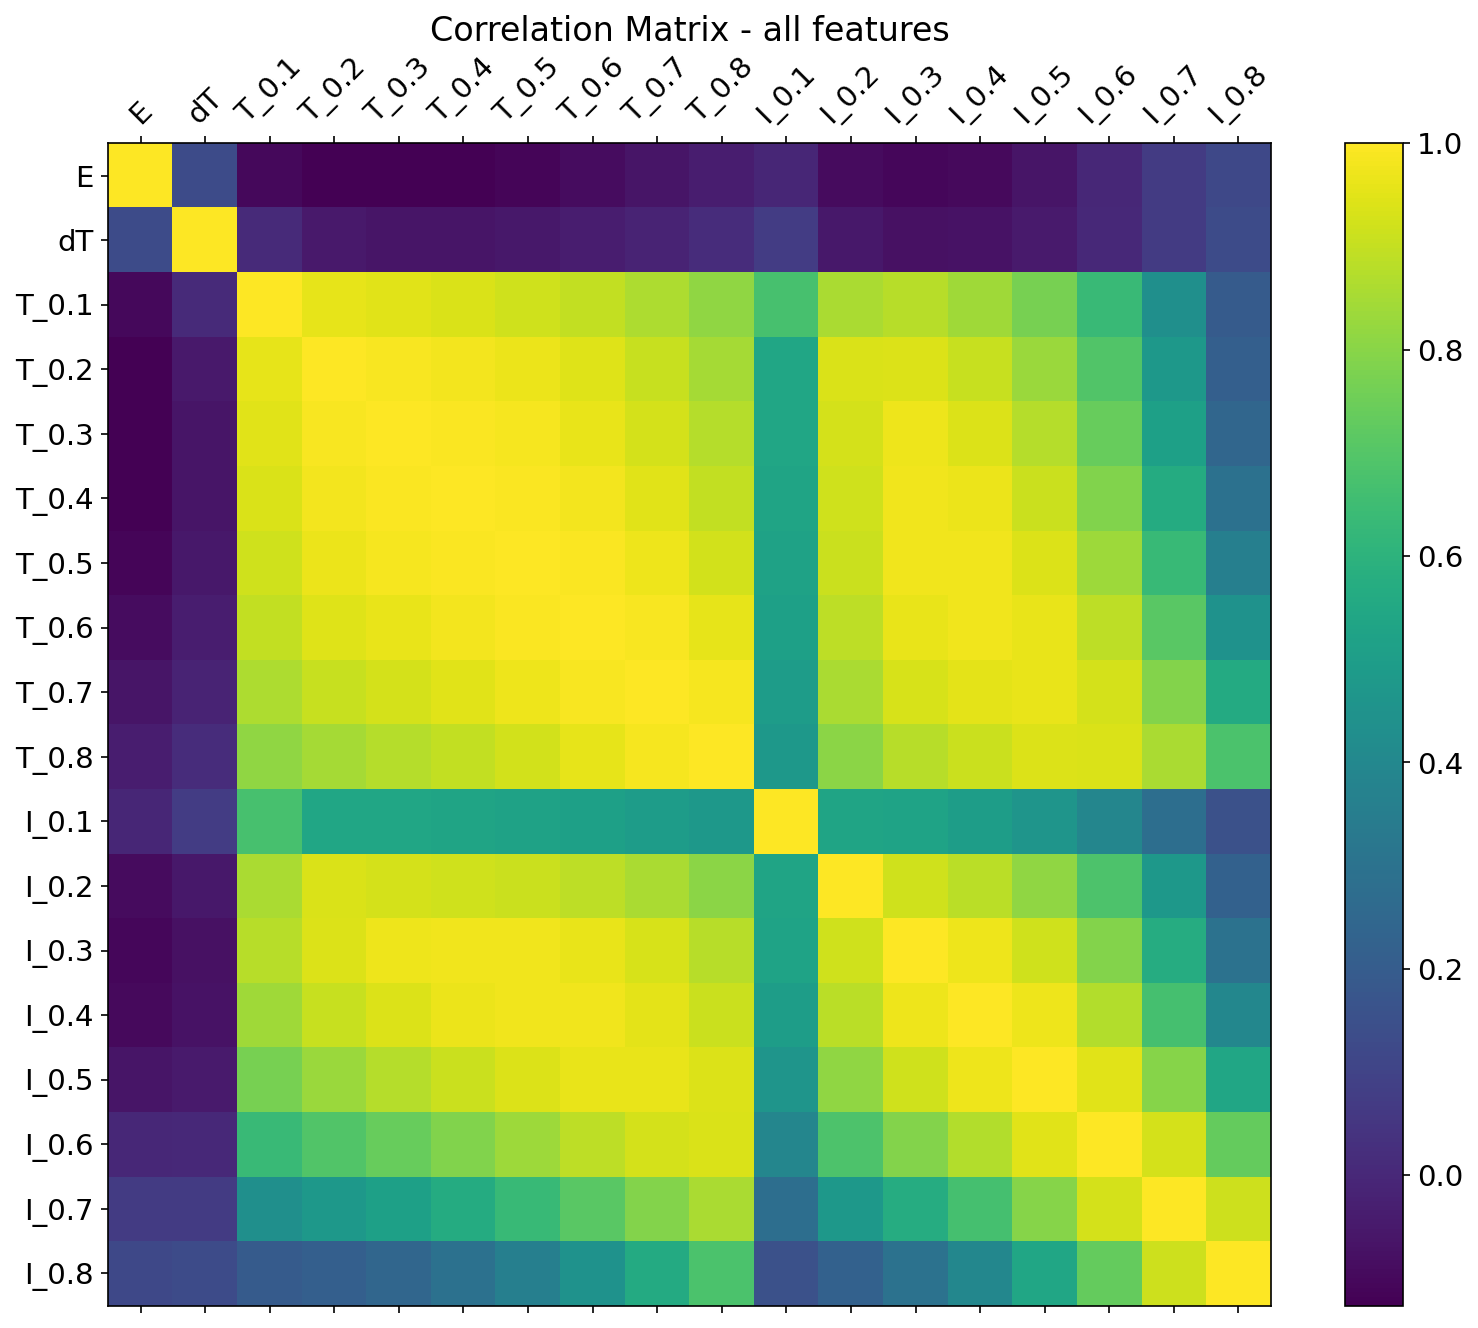

In [18]:
fig = plt.figure(figsize=(12.7, 10)) # 19 15

plt.matshow(data_corr, fignum=fig.number)

plt.xticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('Correlation Matrix - all features', fontsize=16)

# Save figure. Put Plt.show() after
plt.savefig('Correlation Matrix - all features.png', bbox_inches='tight')
plt.show()

**Version 2**

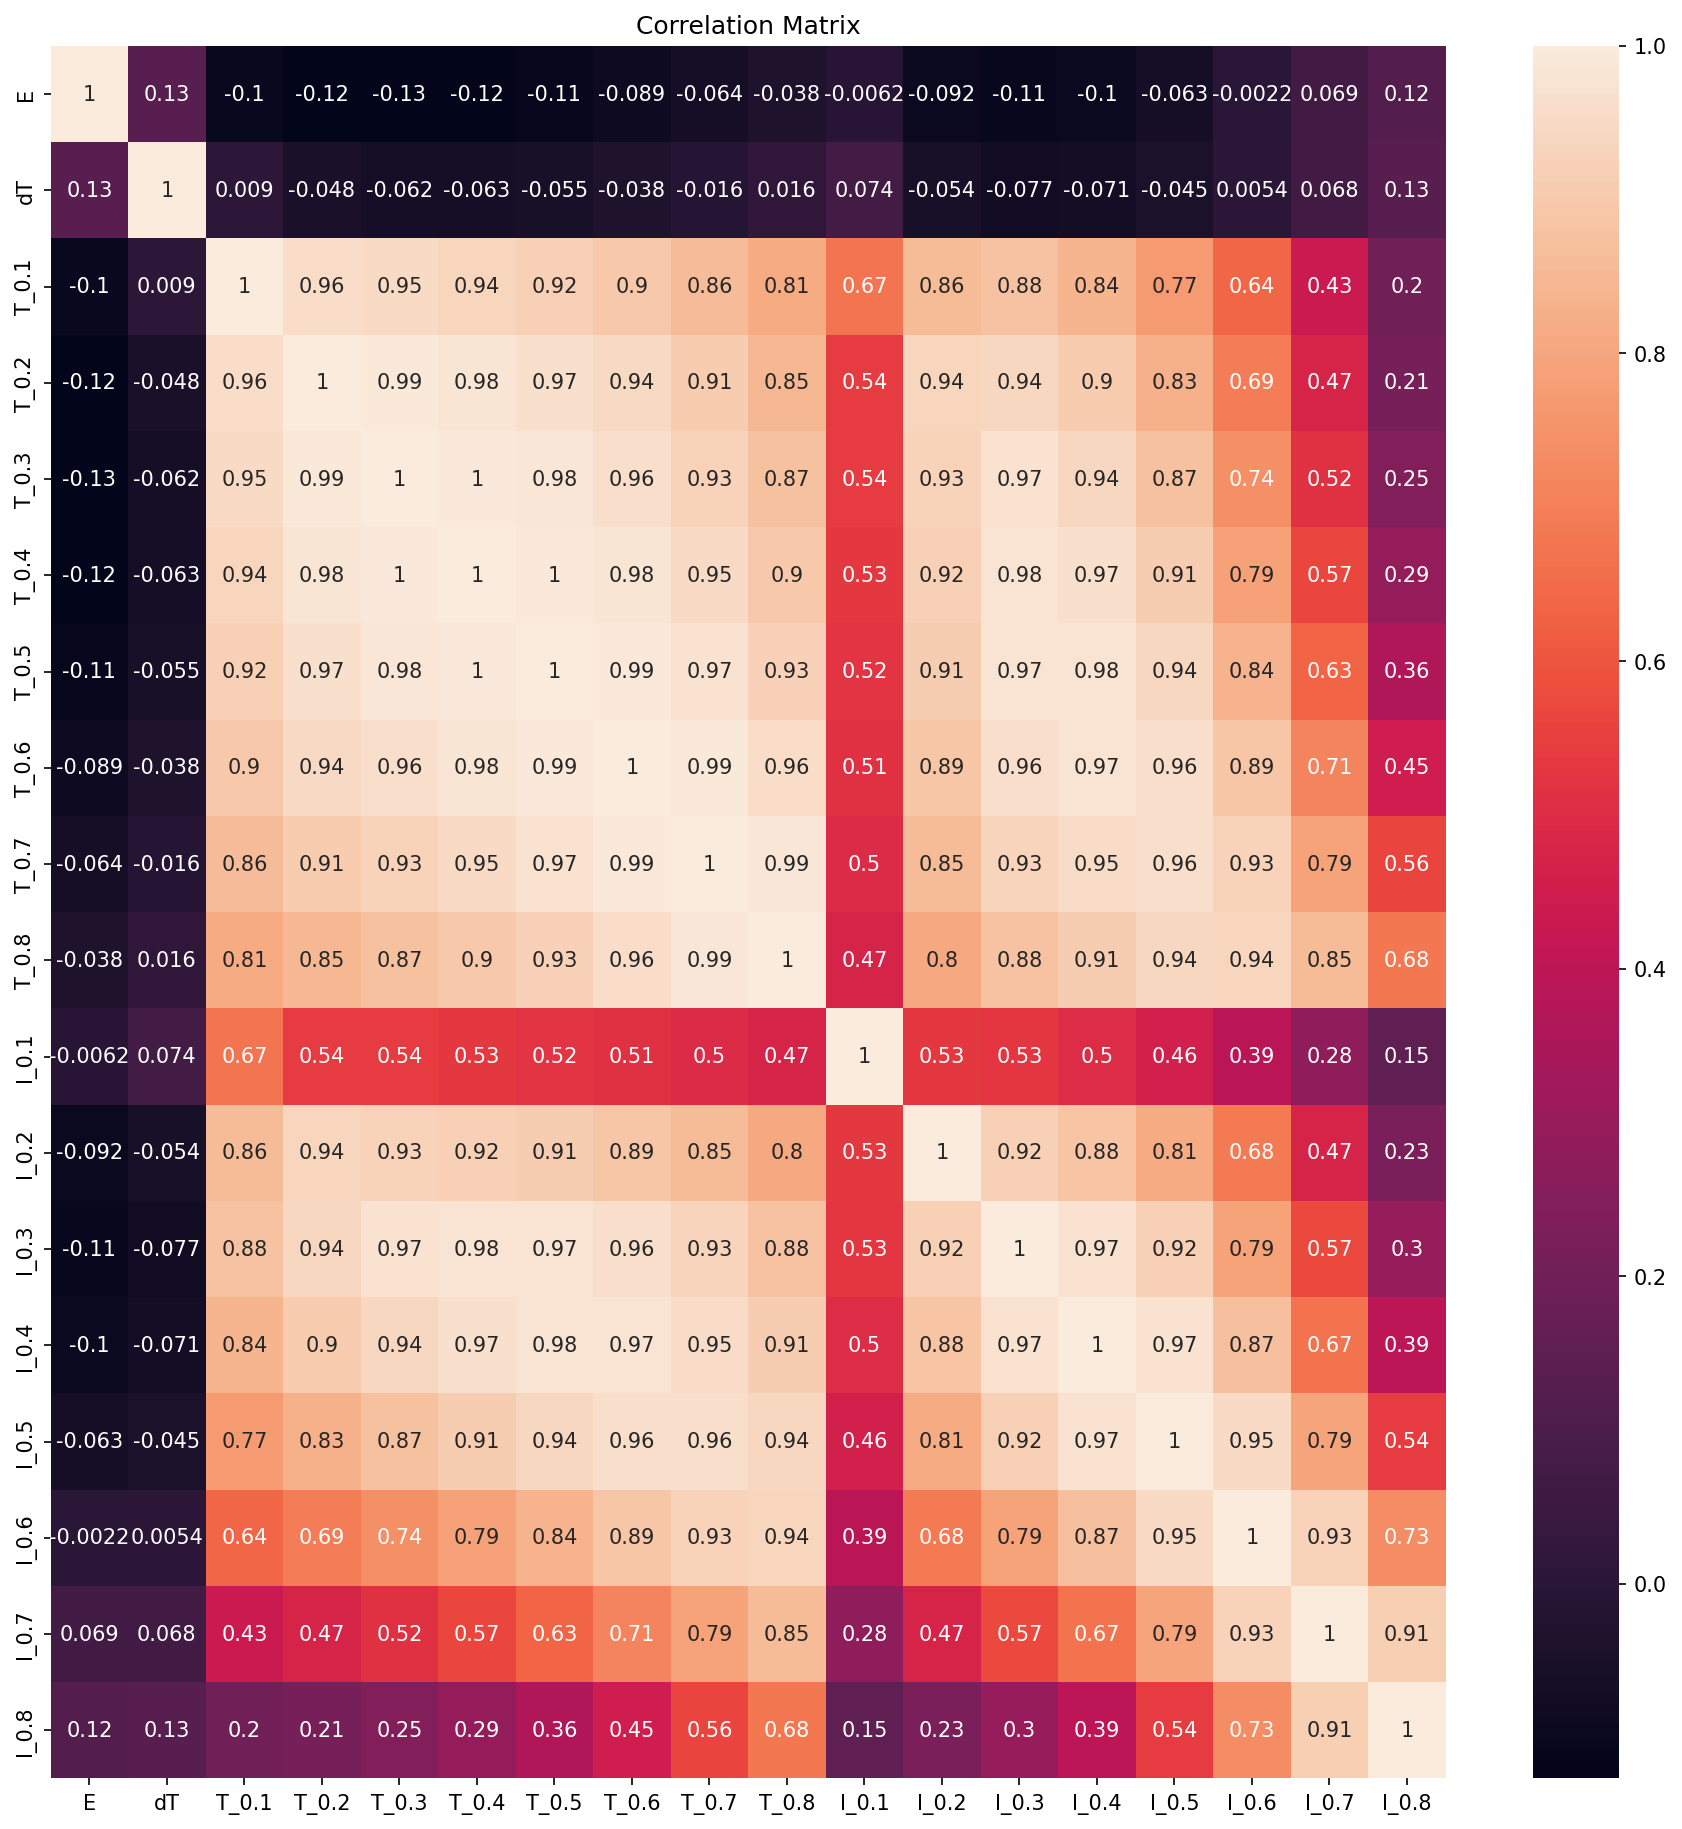

In [17]:
plt.figure(figsize=(15, 15))
ax = plt.subplot()
sns.heatmap(data_corr, annot=True, ax = ax)
ax.set_title('Correlation Matrix')
plt.savefig('Correlation Matrix 2 - all features.png', bbox_inches='tight')

### Pairwise Correlation

**Important Functions**

In [19]:
# --- Create a display function

# Treat columns as indices
# Use indices to refer back to the names
col_index= {i: c for i, c in enumerate(data_corr.columns)}

def correlation_plotter(ax, index=1, threshold=0, print_val=False,
                       zoom=False):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the correlation using the 'index' row. Additional features:
    
    - plots the absolute value only, but in different colors depending on the sign
    - prints the values and columns exceeding an imposed threshold
    - dynamically changes the scaling of the y axis for zooming in
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - index = Integer. It denotes the number of the row to be compared 
    with all other features. To see which column index corresponds to, 
    evaluate 'col_index[index]'
    - threshold = Float. It denoted the value to be exceeded by the
    absolute value of the correlations
    - print_val = Boolean. If true, it displays which columns exceed the
    threshold mentioned above
    - zoom = Boolean. If true, it dynamically changes the yrange such that
    one focuses only on values between 0 and roughly the maximum of the achieved
    correlations
    
    --- Returns:
    
    - axis is changed according to the specifications
    - if print_val=True, the columns above the threshold are printed
    """
    
    # Interested only in correlations excluding the variable itself
    mask = data_corr_np[index] < 1
    corr = data_corr_np[index][mask]  
    
    # xticks for plotting convenience
    xticks = np.array([1 + 3*i for i in range(len(corr))])
    
    # Separate the correlations via signs for different colors
    mask_pos = corr >= 0
    mask_neg = np.logical_not(mask_pos)
    
    corr_pos = corr[mask_pos]
    corr_neg = np.abs(corr[mask_neg])
    
    xticks_pos = xticks[mask_pos]
    xticks_neg = xticks[mask_neg]
    
    # Identify all points above the threshold
    if threshold > 0:
        _ = np.nonzero(np.abs(corr) > threshold)[0]
        # Offset values after the deleted index by 1
        # so it prints the correct column
        _[_ > index] += 1
        
        if print_val == True:
            if len(_) == 0:
                print(f"No correlations above {threshold}")
            else:
                print(f"{col_index[index]}. Columns over threshold: {[col_index[i] for i in _]}")
    
    # The plotting itself
    ax.set_title(f"Correlations - {col_index[index]} ", fontsize=15)
    
    if threshold > 0:
        ax.hlines(y=threshold, xmin=0, xmax=xticks[-1] + 1, 
                  color="black", linestyle=":", label="Threshold")
    
    ax.scatter(xticks_pos, corr_pos, c="blue", s=5, label="Positive")
    ax.scatter(xticks_neg, corr_neg, c="red", s=5, label="Negative")

    ax.grid(axis='y')
    ax.legend(fontsize=8)

    ax.set_ylabel(f"{col_index[index]}", fontsize=12)
    ax.set_xlim(0, xticks[-1] + 1)
    
    # Dynamically change the yrange -- TO BE FIXED
    if zoom == True:
        ymax = min(1, 0.1*np.ceil(10 * np.max(np.abs(corr))))
        ax.set_ylim(0, ymax)
    else:
        ax.set_ylim(0, 1)
    
    _ = np.nonzero(np.logical_not(mask))[0][0] # Drop the removed variable from ticks
    ax.set_xticks(xticks, data_corr.drop(columns=[col_index[_]]).columns, fontsize=10, rotation=45)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    


dT. Columns over threshold: ['E', 'T_0.3', 'T_0.4', 'T_0.5', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.7', 'I_0.8']


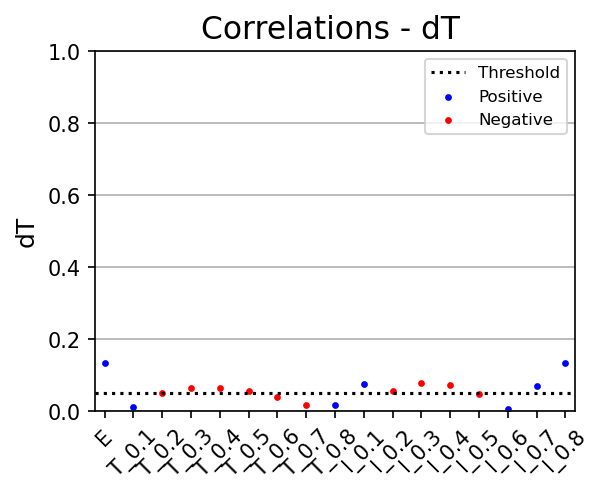

In [21]:
#-> Display correlations of dT versus the rest

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.5, 0.5])
correlation_plotter(ax, index=1, threshold=0.05, print_val=True, zoom=True)

# Save figure
plt.savefig('Correlations - dT vs all.png', bbox_inches='tight')

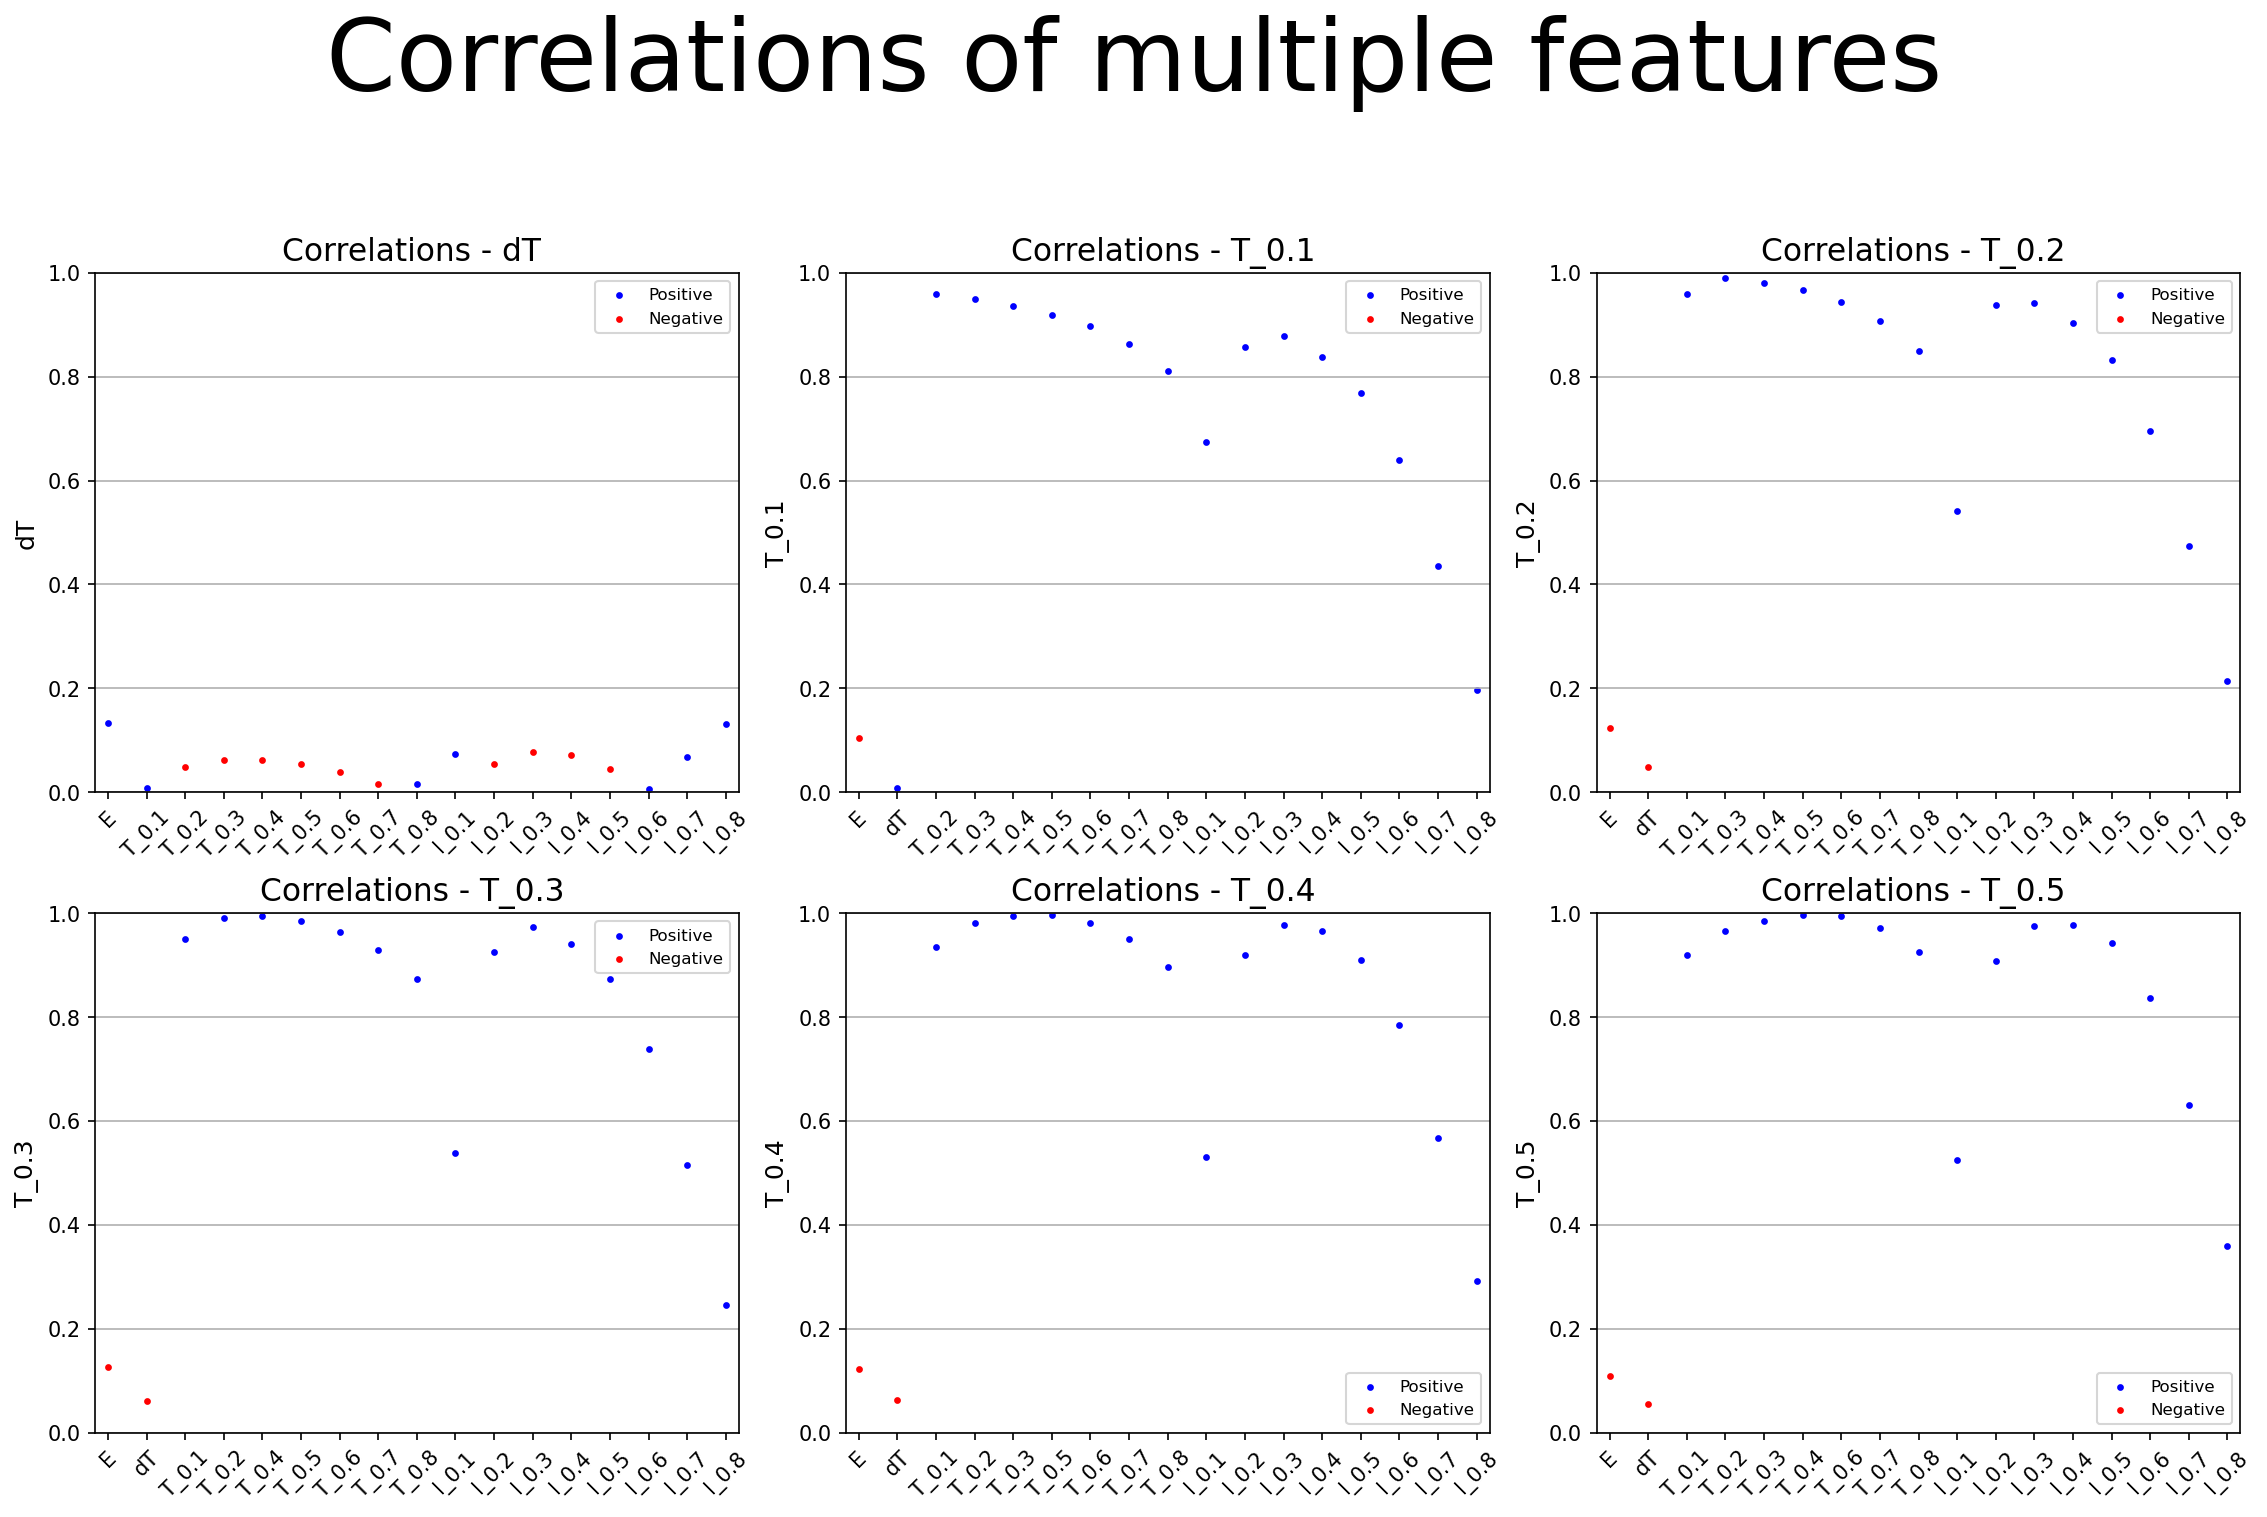

In [22]:
#-> Create subplots of correlations

# Define the indices where we want to analyze correlations
indices = [1, 2, 3, 4, 5, 6]
num_rows = len(indices) // 3

fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

# Plot each correlation
for index, ax in zip(indices, axs.flatten()):
    correlation_plotter(ax, index=index)
    
fig.suptitle('Correlations of multiple features\n', size=48)

#plt.savefig('Correlations of multiple features.png', bbox_inches='tight')
plt.show()

## Scatter Plots and Histograms

**Important functions**

In [38]:
#--- Define a function to do the scatter plot:

def scatter_plotter(ax, index_1, index_2):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the data set. 
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - index_1, index_2 = Integers. It denotes the index of the features
    to be plotted against each other. To see which column index corresponds to, 
    evaluate 'col_index[index]'.
    e.g. col_index[0] = E
    
    --- Returns:
    
    - axis is changed according to the specifications
    """
    
    # Transpose to easily plot columns
    data_ = data_np.T
    
    # The plotting
    ax.set_title(f"{col_index[index_2]} vs. {col_index[index_1]}", fontsize=15)
    
    ax.scatter(data_[index_1], data_[index_2], c="blue", s=5, label="Data")
    ax.legend(fontsize=8)
    
    ax.set_xlabel(f"{col_index[index_1]}", fontsize=12)
    ax.set_ylabel(f"{col_index[index_2]}", fontsize=12)
    
def scatter_matrix_plotter(indices_1, indices_2, save_fig=False):
    """
    Creates a scatter mattrix plot of each feature given by
    indices_1 and indices_2. It relies on the function 
    scatter_plotter.
    
    --- Inputs:
    
    indices_1, indices_2 = Array-like. Each contains a list of all index_1, 
    respectively index_2 variables to be used by scatter_plotter. Both must
    have the same length!
    
    save_fig = Boolean. If true, it saves the subplots as a PNG
    
    --- Returns:
    
    A subplot.
    """
    
    num_rows = len(indices_1) // 3
    
    fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

    for index_1, index_2, ax in zip(indices_1, indices_2, axs.flatten()):
        scatter_plotter(ax, index_1=index_1, index_2=index_2)

    fig.suptitle('Scatter plot of multiple features\n', size=48)
    
    if save_fig == True:
        plt.savefig('Scatter plots of dT.png', bbox_inches='tight')
    
    plt.show()
    
# --- Functions to compute the histograms

def histogram_plotter(ax, model_name, popt):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the data set. A histogram plot of dT and a fit to the model.
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - model_name = String. Must be from the 'models' dictionary
    (as of now: Normal, Lorentzian).
    - popt = array-like. The values of the parameters to be passed to the 
    model function plotted alongside the data
    
    --- Returns:
    
    - axis is changed according to the specifications
    """
    
    # Extract variables
    f = models[model_name]
    
    # Fit function - arrays
    x_vals = np.linspace(x_pdf.min(), x_pdf.max(), 1000)
    y_vals = f(x_vals, *popt)
    
    # The plotting
    ax.set_title(f"Model: {model_name}", fontsize=15)
    
    ax.scatter(x_pdf, y_pdf, c="blue", s=5, label="Data histogram")
    ax.plot(x_vals, y_vals, color="red", label="Model fit")
    
    ax.legend(fontsize=8)
    ax.set_xlabel(r"$dT$ values", fontsize=12)
    ax.set_ylabel(r"Frequency", fontsize=12)
    
def histogram_subplotter(save_fig=False):
    """
    Creates a subplot of each model given from "models". It relies on the function 
    histogram_plotter.
    
    --- Inputs:
    
    indices_1, indices_2 = Array-like. Each contains a list of all index_1, 
    respectively index_2 variables to be used by scatter_plotter. Both must
    have the same length!
    
    save_fig = Boolean. If true, it saves the subplots as a PNG
    
    --- Returns:
    
    A subplot.
    """
    
    num_rows = max(len(models) // 3, 1)
    
    fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

    for ax, model_name, popt in zip(axs.flatten(), models.keys(), popt_list):
        histogram_plotter(ax, model_name, popt)

    fig.suptitle('Histogram with multiple models\n', size=48)
    
    if save_fig == True:
        plt.savefig('Histogram plots of dT.png', bbox_inches='tight')
    
    plt.show()

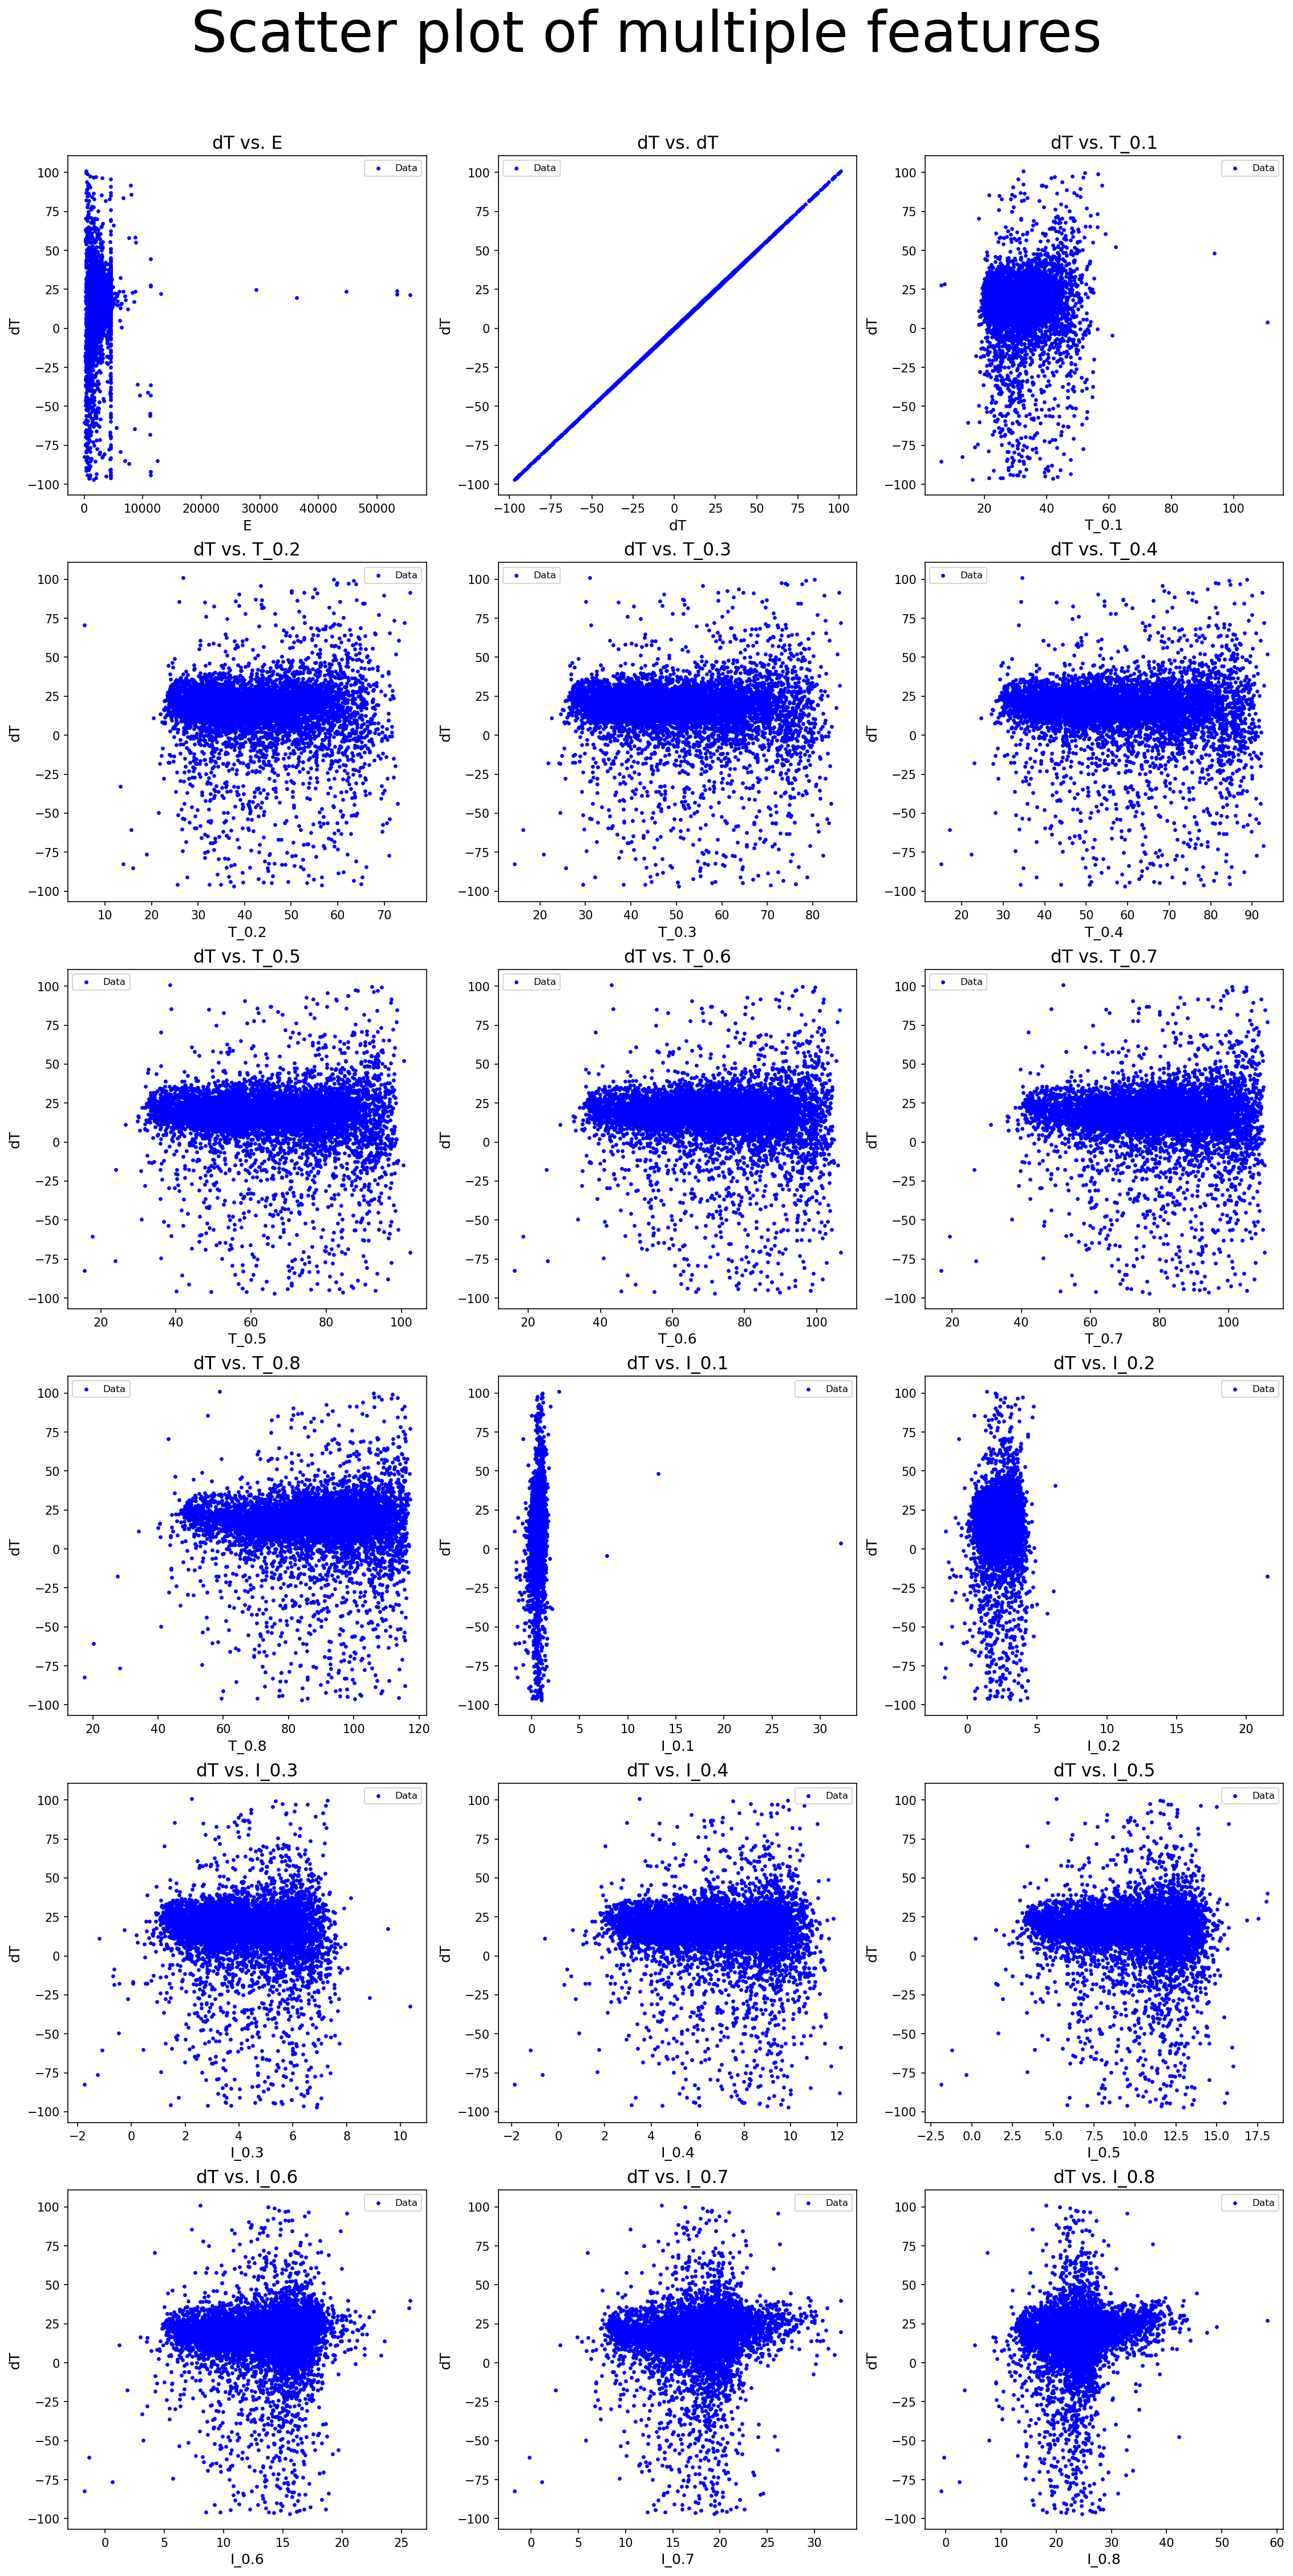

In [43]:
#--- Scatter plots

# Define the indices to analyze
indices_1 = np.arange(0, data_np.shape[1])
indices_2 = np.ones(len(indices_1), dtype=np.int8)  # Corresponding to dT

scatter_matrix_plotter(indices_1, indices_2,
                      save_fig=True)

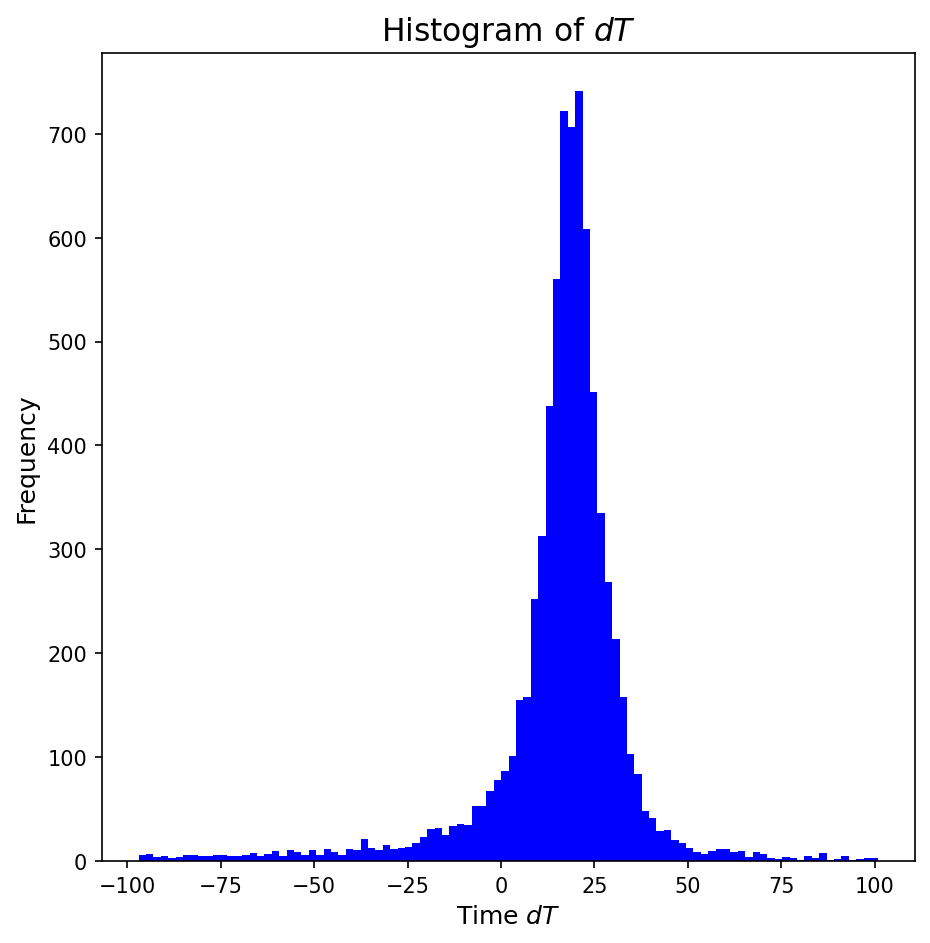

In [44]:
# --- Create a raw histogram of dT

fig = plt.figure(figsize=(7, 7))

plt.title(r"Histogram of $dT$", fontsize=15)

plt.hist(data_np.T[1], bins=100, color="blue")

plt.xlabel(r"Time $dT$", fontsize=12)
plt.ylabel(r"Frequency", fontsize=12)

plt.savefig('Histogram of dT - Raw.png', bbox_inches='tight')
plt.show()

#### Fit functions to histogram

In [48]:
#--- Create a histogram 

y_pdf, bins = np.histogram(data_np.T[1], bins=800, density=True)
x_pdf = (bins[:-1] + bins[1:])/2

#--- Test whether the distribution is normal

print(sps.normaltest(data_np.T[2]))
print(sps.normaltest(y_pdf))

#--- Fit functions to the histogram:

models = {
    "Normal": lambda x, a, b: sps.norm.pdf(x, loc=a, scale=b),
    "Lorentzian": lambda x, a, b: sps.cauchy.pdf(x, loc=a, scale=b)
}

popt_list = []
pcov_list = []

for f in models.values():
    popt, pcov = sop.curve_fit(f, x_pdf, y_pdf,)
    
    popt_list.append(popt)
    pcov_list.append(pcov)

NormaltestResult(statistic=1689.665793738875, pvalue=0.0)
NormaltestResult(statistic=490.0692317206107, pvalue=3.826647486827125e-107)


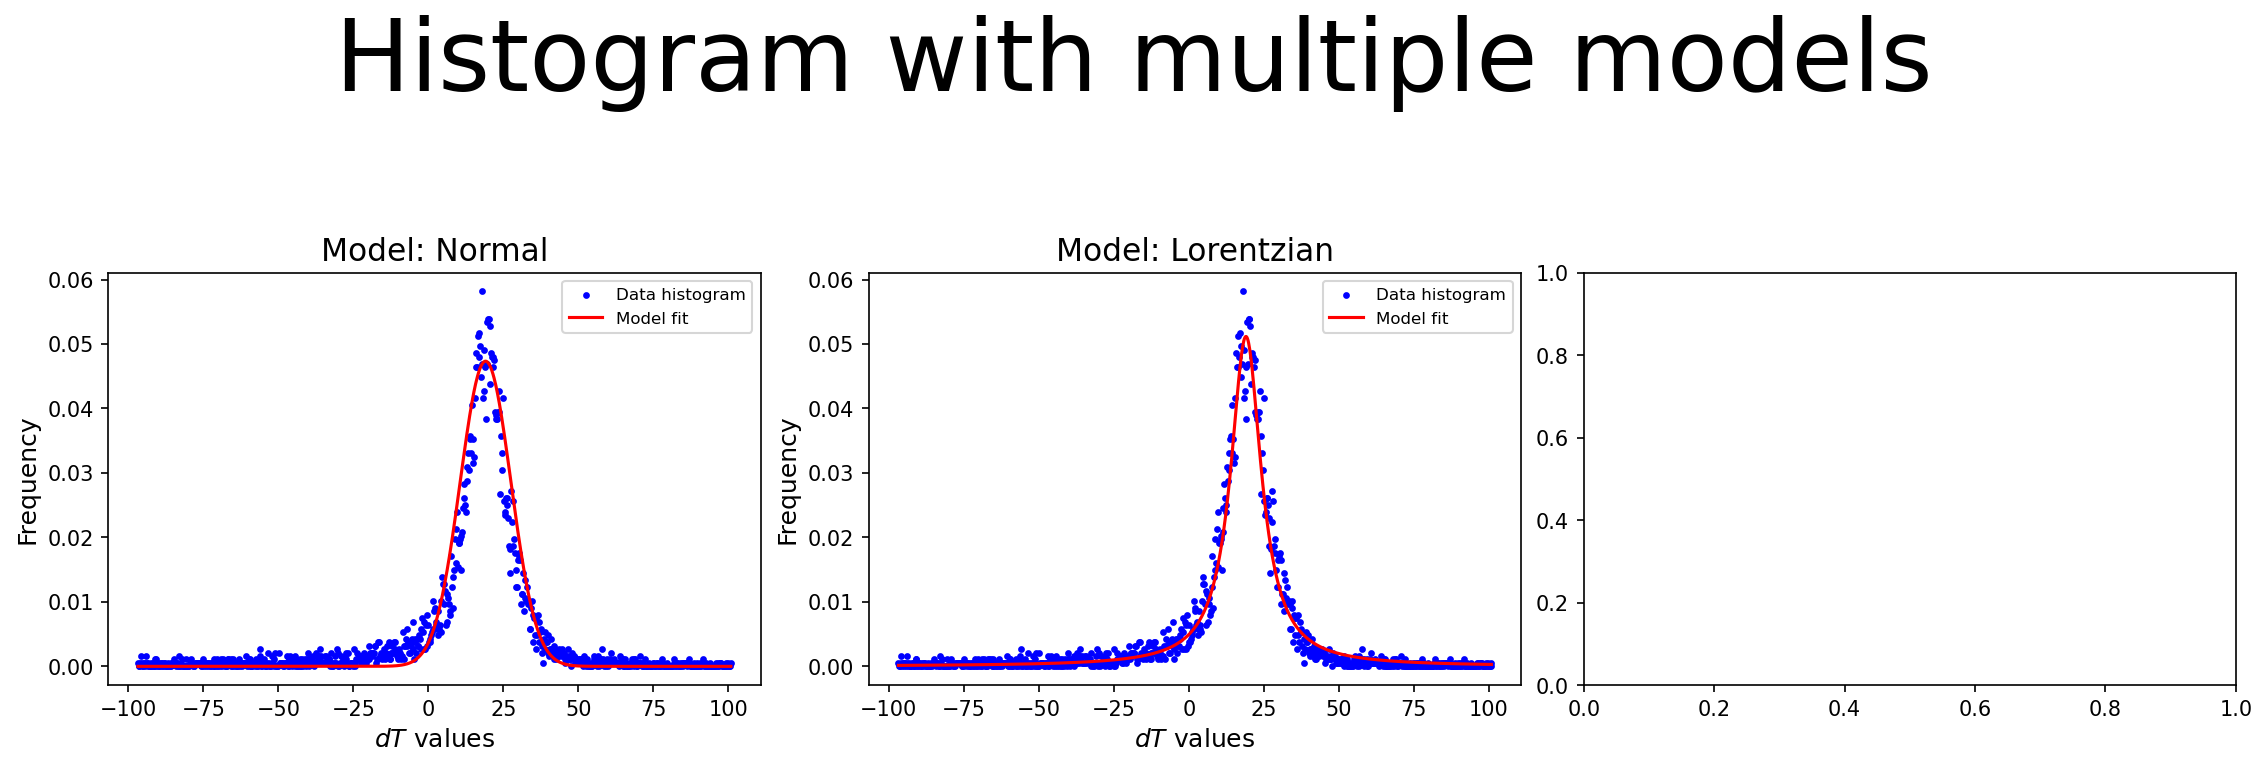

In [49]:
histogram_subplotter(save_fig=False)

# Training Models

**Select features and Split the data set**

- all I's:                 ['I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6','I_0.7', 'I_0.8']
- middle I's, middle T's:  ['T_0.3', 'T_0.4', 'T_0.5', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5']
- all I's, middle T's:     ['T_0.3', 'T_0.4', 'T_0.5', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6','I_0.7', 'I_0.8']
- all T's:                 ['T_0.1', 'T_0.2', 'T_0.3', 'T_0.4', 'T_0.5', 'T_0.6', 'T_0.7', 'T_0.8']

In [3]:
#--- Select features and convert to NP

def get_data_features(features_list, data_set=data,
                      test_size=0.3, random_state=42):
    """
    This function takes the pandas data frame 'data_set'
    and splits it into a training and a testing set.
    Only the features in 'features_list' are kept among
    the column of covariates.
    
    --- Inputs:
    
    features_list = list. It contains the columns of the covariates
    that will be kept for later training
    
    data_set = pandas data frame. The data set to be split
    
    test_size = float. The proportion of the data set that will
    be returned as a test set
    
    random_state = integer. The seed that is provided to the random
    splitting of the data set
    
    --- Outputs:
    
    list with 4 elements, each representing 
    X_train, X_test, Y_train, Y_test
    
    """
    
    # Change to the features list that I want to investigate
    Y = data_set[["dT"]]
    X = data_set[features_list]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=42)
    
    # To numpy
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    Y_train_np = Y_train.to_numpy()
    Y_test_np = Y_test.to_numpy()
    
    return [X_train_np, X_test_np, Y_train_np, Y_test_np]

In [4]:
features_list_list = [["I_0.1", "I_0.2", "I_0.3", "I_0.4", "I_0.5", "I_0.6", "I_0.7", "I_0.8"],
                      ["T_0.3", "T_0.4", "T_0.5", "I_0.2", "I_0.3", "I_0.4", "I_0.5"],
                      ['T_0.3', 'T_0.4', 'T_0.5', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6','I_0.7', 'I_0.8'],
                      ["T_0.1", "T_0.2", "T_0.3", "T_0.4", "T_0.5", "T_0.6", "T_0.7", "T_0.8"]]

# To change the features you focus on, select another item
# in the list by changing 0 to another integer
features_list = features_list_list[0]

# Convert data in numpy format with given features
data_np = get_data_features(features_list)

# Extract output shape
input_shape_ = (len(features_list),)

In [6]:
data_np[0].shape, data_np[1].shape, data_np[2].shape, data_np[3].shape

((5304, 8), (2274, 8), (5304, 1), (2274, 1))

**Important functions**

In [5]:
#--- Function to predict the values

def get_predictions(model, data=data_np,
                   plot_hist=False,
                   add_labelvals=False):
    """
    This function predicts both the training and the 
    test data, given a model. It can also plot a histogram
    of the predicted values against the label values.
    
    --- Inputs:
    
    model = tensorflow or sklearn object. It must be a model already
    defined and trained on the data, prior to calling
    this function
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**, which represent the data set on which the model was trained 
    on and on which it is to be tested. 
    Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_hist = Boolean. If true, the function also returns
    a histogram plot of the predicted values, split into training
    and testing sets
    
    add_labelvals = Boolean. If true, to the above histogram the 
    histogram for the label values is also overlapped
    
    --- Returns:
    
    Matplotlib figure, if the option is enabled.
        
    (Yhat_train, Yhat_test) = A tuple with the predicted arrays
    for both train data and test data
    """
    
    # Obtain sizes
    N_train = len(data[2])
    N_test = len(data[3])
    N_total = N_train + N_test
    
    # Predict
    Yhat_train = model.predict(data[0])
    Yhat_test = model.predict(data[1])
        
    # Plot the histogram of predicted dT (and maybe label dTs)
    if plot_hist == True:       
        # Reshape arrays for plotting purposes
        Yhat_train_reshaped = Yhat_train.reshape((N_train,))
        Yhat_test_reshaped = Yhat_test.reshape((N_test,))
        Y_train_np_reshaped = data[2].reshape((N_train,))
        Y_test_np_reshaped = data[3].reshape((N_test,))

        # Plot
        fig = plt.figure(figsize=(5, 3))
        
        plt.hist(Yhat_train_reshaped, bins=N_total//100, alpha=0.5, color="r",
                 density=False, label="Predicted - train")
        
        plt.hist(Yhat_test_reshaped, bins=N_total//100, alpha=0.5, color="b",
                 density=False, label="Predicted - test")
        
        if add_labelvals == True:
            
            plt.hist(Y_train_np_reshaped, bins=N_total//100, alpha=0.5, color="green",
                     density=False, label="Label - train")
            
            plt.hist(Y_test_np_reshaped, bins=N_total//100, alpha=0.5, color="orange",
                     density=False, label="Label - test")
        
        plt.title("Predicted dT values", fontsize=15)
        plt.xlabel("dT", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.legend()
        plt.show()
    
    return (Yhat_train, Yhat_test)

def get_residues(fitted_values, data=data_np,
                plot_residues=False, 
                test_norm=False):
    """
    This function computes the residues, which are defined as
    $$ y_{label, from data set} - \hat{y}_{prediction}$$
    
    It can also plot a histogram of the predicted values against 
    the label values, and test for the normality of the distribution of
    residues.
    
    --- Inputs:
    
    fitted_values = list or tuple. Its format is (Yhat_train, Yhat_test)
    as returned by get_predictions()
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**, which represent the data set on which the model was trained 
    on and on which it is to be tested. 
    Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_residues = the histogram of residues for predicted and
    label data
    
    test_norm = applies a normality test to see if the residues are
    normally distributed. The closer to normality they are, the better
    the initial prediction.
    
    --- Returns:
    
    Matplotlib figure, if the option is enabled.
        
    (residue_train, residue_test) = A tuple with the arrays of residues
    for both train data and test data
    """
    
    # Obtain predictions
    Yhat_train, Yhat_test = fitted_values
    
    # Obtain sizes
    N_train = len(data[2])
    N_test = len(data[3])
    N_total = N_train + N_test
    
    # Compute residues
    residue_train = data[2] - Yhat_train
    residue_test = data[3] - Yhat_test
    
    # Plot the histogram of residues
    if plot_residues == True:
        # Reshape arrays for plotting purposes
        residue_train_reshaped = residue_train.reshape((N_train,))
        residue_test_reshaped = residue_test.reshape((N_test,))
        
        # PLot
        fig = plt.figure(figsize=(5, 3))
        
        plt.hist(residue_train_reshaped, bins=N_total//100, alpha=0.3,
                 density=True, color="b", label="Train")
        
        plt.hist(residue_test_reshaped, bins=N_total//100, alpha=0.3,
                 density=True, color="r", label="Test")
        
        plt.title("Residue distribution", fontsize=15)
        plt.xlabel("Residue", fontsize=12)
        plt.ylabel("Normalized frequency", fontsize=12)
        plt.legend()
        plt.show()
    
    # Normal Test
    if test_norm == True:
        pval_train = sps.normaltest(residue_train).pvalue
        pval_test = sps.normaltest(residue_test).pvalue
        
        print(f"p-value for normality of train: {pval_train}")
        print(f"p-value for normality of test: {pval_test}\n")
    
    return (residue_train, residue_test)

def get_resolutions(residues,
                  method="std"):
    """
    The function returns the resolution of the predictions
    for both the training and the testing data sets.
    
    The resolution can be defined in multiple ways:
    - as the standard deviation of all residues ("std")
    - as the mean of the absolute value of all residues ("mean")
    
    --- Inputs:
    
    residues = A tuple with the arrays of residues
    for both train data and test data. 
    Note: = the return of get_residues()
    
    method = string. It determines which definition is applied when 
    finding the resolution. See the definitions above for the options
    
    --- Outputs:
    
    A tuple (resolution_train, resolution_test) containing the resolutions
    for both the training and the testing sets.
    """
    
    # Resolutions
    if method == "std":
        resolution_train = np.std(residues[0])
        resolution_test = np.std(residues[1])
        
        return (resolution_train, resolution_test)
    
    elif method == "mean":
        resolution_train = np.mean(np.abs(residues[0]))
        resolution_test = np.mean(np.abs(residues[1]))
        
        return (resolution_train, resolution_test)
    
    else:
        print("Invalid method!")
        return (np.inf, np.inf)

#--- Define joint function for ease of implementation:

def predictor(model, data=data_np,
              plot_hist=False,  
              add_labelvals=False,
              plot_residues=False,
              test_norm=False,
              add_resolutions=False,
              method='std'):
    """
    This function provides an integrated API for calling
    all three of the functions above. Mainly for comfort 
    purposes.
    
    --- Inputs:
    
    model = tensorflow or sklearn object. It must be a model already
    defined and trained on the data, prior to calling
    this function
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**, which represent the data set on which the model was trained 
    on and on which it is to be tested. 
    Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_hist = Boolean. If true, the function also returns
    a histogram plot of the predicted values, split into training
    and testing sets
    
    add_labelvals = Boolean. If true, to the above histogram the 
    histogram for the label values is also overlapped
    
    plot_residues = the histogram of residues for predicted and
    label data
    
    test_norm = applies a normality test to see if the residues are
    normally distributed. The closer to normality they are, the better
    the initial prediction.
    
    add_resolutions = Boolean. If true, it prints nicely the 
    resolutions corresponding to each data set (train/test).
    
    method = string. It determines which definition is applied when 
    finding the resolution. See the definitions above for the options
    
    --- Outputs:
    
    Depending on which boolean is set to true, it returns 
    figures or printed statements.
    """
    
    # Predict the data
    predictions = get_predictions(model, data=data, plot_hist=plot_hist,
                                 add_labelvals=add_labelvals)
    # Compute residues
    residues = get_residues(predictions,
                            plot_residues=plot_residues, test_norm=test_norm)
    
    # Find resolution
    if add_resolutions == True:
        resolutions = get_resolutions(residues, method=method)
        
        print(f"Method: {method}")
        print(f"Resolution - train set: {resolutions[0]}")
        print(f"Resolution - test set: {resolutions[1]}")

## Neural Networks Regression

**Functions that generate, train and save Sequential NN models**

In [6]:
#--- Define function to create a model

def get_model(nodes_per_layer: list,
             input_shape: tuple = input_shape_,
             hidden_layer_activation: str = 'relu',
             num_nodes_at_output: int = 1,
             output_layer_activation: str = 'linear'):
    """
    This function creates a tensorflow (keras) sequential model,
    but without actually compiling the model. 
    
    --- Input:
    
    nodes_per_layer = list. It gives the number of nodes that 
    each layer will have, in order. Its length is the number of 
    hidden layers
    
    input_shape = tuple. It gives the shape of the input layer;
    It is of the form (#Features,) - ignoring the number of data
    points
    
    hidden_layer_activation = string. It gives the activation function
    of the hidden layers. 
    
    num_nodes_at_output = integer. It gives the number of nodes that
    the output layer has
    
    output_layer_activation = string. It gives activation function of the
    output layer. By default it is set to 'linear', which is appropriate
    for a regression task
    
    --- Output:
    
    model = keras.src.engine.sequential.Sequential. A non-compiled
    tensorflow sequential model
    """
    
    # Create sequential model
    model = tf.keras.Sequential()
    
    # Change name for ease of tracking
    model_name = ''
    model_name += hidden_layer_activation + '_'
    
    # Add input layer
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    # Add the hidden layers
    for nodes in nodes_per_layer:
        model.add(tf.keras.layers.Dense(nodes, activation=hidden_layer_activation))
        # Append to name
        model_name += f'{nodes}_'
    
    # Add output layer
    model.add(tf.keras.layers.Dense(num_nodes_at_output, activation=output_layer_activation))
    
    # Set the name of the model
    model._name = model_name[:-1]
    
    return model

#--- Define function to create many models:

def get_models(nodes_per_layer_list: list,
               input_shape: tuple = input_shape_,
               hidden_layer_activation: str = 'relu',
               num_nodes_at_output: int = 1,
               output_layer_activation: str = 'linear'):
    """
    The function generates a list of models, as created by the
    get_model() function. The only difference is that now each 
    model will have nodes_per_layer as given by the elements of 
    nodes_per_layer_list.
    """
    
    # Create a list of models   
    models = []
    
    for nodes_per_layer in nodes_per_layer_list:
        temp = get_model(nodes_per_layer, input_shape=input_shape,
                        hidden_layer_activation=hidden_layer_activation,
                        num_nodes_at_output=num_nodes_at_output,
                        output_layer_activation=output_layer_activation)
        models.append(temp)
    
    return models

#--- Function to train a model

def train(model, 
         data=data_np,
         loss=tf.keras.losses.mse,
         optimizer=tf.keras.optimizers.Adam(),
         metrics=['mse'],
         batch_size=None):
    """
    The function compiles and trains a tf sequential
    model to the training data data.
    
    --- Inputs:
    
    model = tf.sequential.Sequential object. The tensor
    flow model to be modified
    
    data = list. It consists of a list [X, Y] containing the 
    training data and testing data. See predictor() for details
    
    loss, optimizer = tf.keras objects. They represent the 
    loss function and the optimizer to be used when training
    - For more on optimizers, check the following link:
    https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
    - Learning rate: It roughly represents the size of the
    steps when searching for the minimum of the loss function.
    The exact interpretation depends on the optimizer
    - To change the learning rate, call 
    train(..., optimizer=your_function(learning_rate=chosen_float))
    
    metrics = list. It is a list contaning a string with the
    metric that is optimized when fitting the function. An 
    alternative to this is ['mae'].
    
    batch_size = Integer or None. Number of samples per gradient update,
    used to do backpropagation in gradient descent.
    If unspecified, batch_size will default to 32.
    See the following link for more details, at the .fit() method:
    https://www.tensorflow.org/api_docs/python/tf/keras/Model
    
    learning_rate = float. 
    
    --- Outputs:
    
    None. The model in the argument is modified and fitted
    """
    
    # Compile the model
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    
    # Fit the model - distinguish if batch_size is provided or not
    if(type(batch_size) == int):
        model.fit(data[0], data[2], epochs=100, verbose=0,
                 batch_size=batch_size)
    else:
        model.fit(data[0], data[2], epochs=100, verbose=0)
        
#--- Functions that save or load a trained model

def save_model(model, 
        path_folder=paths_on_my_laptop[2]):
    """
    This function saves a given tensorflow model in the folder
    given by the path 'path_folder'
    
    Inspired from:
    https://www.tensorflow.org/guide/keras/serialization_and_saving
    
    --- Returns:
    
    Besides saving the model, the function returns the path of the 
    saved file, including its name and '.keras' extension
    """
    
    # Save
    path_file = path_folder + model.name + '.keras'

    model.save(path_file)
    
    return path_file

def load_model(path_file):
    """
    This function loads a tensorflow model
    given by the path 'path_file'
    
    Inspired from:
    https://www.tensorflow.org/guide/keras/serialization_and_saving
    
    --- Returns:
    
    Tensorflow model. It should already be defined, compiled and fitted 
    to the training data; ready to use for predictions
    """
    
    # Load
    return tf.keras.models.load_model(path_file)

#--- Define a function to create layer-node permutations:

def get_layer_node_permutations(num_layers: int,
               min_nodes_per_layer: int,
               max_nodes_per_layer: int,
               node_step_size: int):
    """
    In mathematical terms, the function generates the cartesian
    product of the set A = range(min_nodes, max_nodes + 1, step_size)
    repeated num_layers times:
    
    A X A X A X ... X A
    
    --- Inputs:
    
    num_layers = Integer. It gives the number of nodes that 
    each layer will have, in order. Its length is the number of 
    hidden layers. In this context: the number of times we take the
    cartesian product
    
    min_nodes_per_layer = Integer. The minimal number of nodes a layer
    is allowed to have.
    
    max_nodes_per_layer = Integer. The maximal number of nodes a layer
    is allowed to have (inclusive).
    
    node_step_size = Integer. The spacing between allowed number of nodes
    
    --- Returns:
    
    A list of tuples. Each tuple consists of a permutation of num_layers
    elements samples from the set A.
    
    --- Example:
    
    get_layer_node_permutations(2, 5, 7, 1)
    > [(5, 5), (5, 6), (5, 7), (6, 5), (6, 6), (6, 7), (7, 5), (7, 6), (7, 7)]
    """
    
    # Possible number of nodes
    node_options = list(range(min_nodes_per_layer, max_nodes_per_layer+1, node_step_size))
    
    # Repeat the above num_layers times
    layer_possibilities = [node_options] * num_layers
    
    # Generate permutations of the above 
    # = all possible arrangements of number of nodes per layer
    layer_node_permutations = list(itertools.product(*layer_possibilities))
    
    return layer_node_permutations

### Test the functions

In [9]:
model_test = get_model([10, 10, 10, 10, 10, 10, 10],
                     hidden_layer_activation='relu')
train(model_test,optimizer=tf.keras.optimizers.legacy.Adam())
model_test.summary()




Model: "relu_10_10_10_10_10_10_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10

72/72 [==============================] - 0s 712us/step


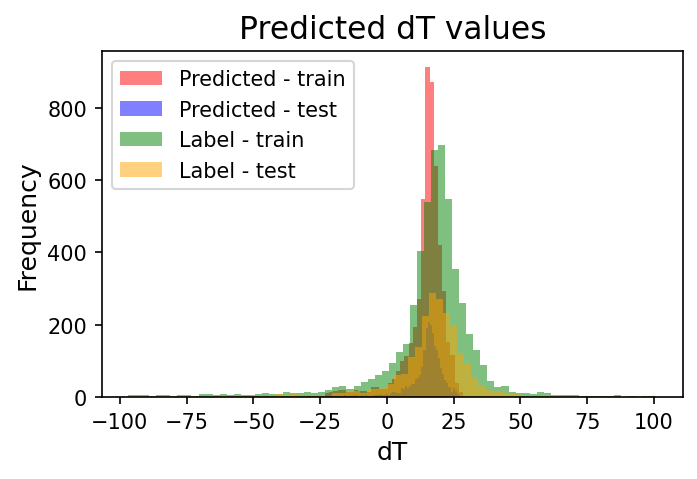

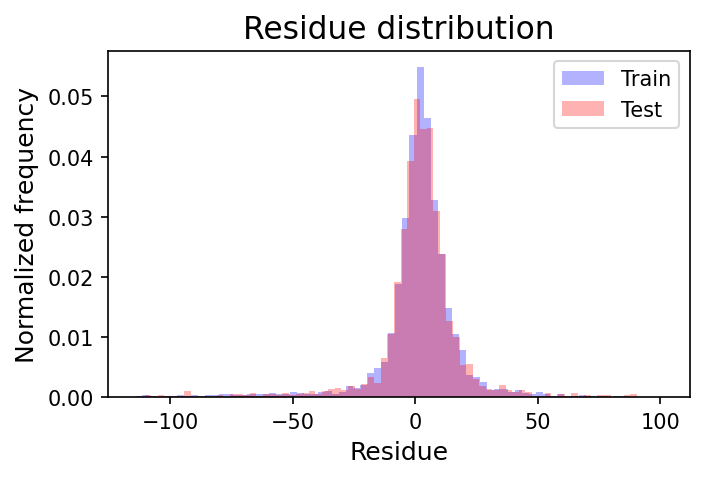

Method: std
Resolution - train set: 17.787605559167204
Resolution - test set: 17.35447622782934


In [14]:
predictor(model_test, plot_hist=True, plot_residues=True,
          add_labelvals=True, add_resolutions=True,)

In [20]:
path_file = save_model(model_test)
path_file

'C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/relu_10_10_10_10_10_10_10.keras'

In [21]:
model_test = load_model('C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/relu_10_10_10_10_10_10_10.keras')
model_test.summary()

Model: "relu_10_10_10_10_10_10_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)  

### Optimize Model Architecture

#### Test Small Hypotheses

In this section, I aim to investigate certain hypotheses on single models. This is to see if changing one characteristic of a model would radically affect the results, to see if a grid search on variants of that characteristic is warranted.

Questions to be answered:

- How impactful are activation functions when it comes to investigating a model?

*Answer 1*. Conditions: learning_rate, batch_size default; [8, 6, 8, 8] layer distribution; 'All I' data set. All functions from 'relu' family perform similarly well on the testing set (resolution \approx 17.46), while 'gelu' does the best on the training set (17.79 'gelu' vs 17.87 'elu' vs. 17.96 'relu'). 

*Conclusion*. 'relu' is fine, but 'gelu' is preferable. 

- How good is each selection of features when it comes to predictive power of the model?

*Answer 1*. Conditions: learning_rate, batch_size default; [8, 6, 8, 8] layer distribution; 'gelu' activation function. The performances on 'All I', 'Middle T & Middle I', 'Middle T & All I', 'All T' were:
Train set - [17.790, 19.001, 17.866, 18.780]
Test set - [17.457, 18.848, 17.540, 18.189]

*Conclusion*. 'All I' > 'Middle T & All I' > 'All T' >> 'Middle T & Middle I'. Using the whole curve is the best from Is is the best.

- How does batch_size affect the results? What about the learning rate?

**Different activation function**

In [23]:
# softplus
model_test_softplus = get_model([8, 6, 8, 8],
                     hidden_layer_activation='softplus')
train(model_test_softplus,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np)

# Linear
model_test_linear = get_model([8, 6, 8, 8],
                     hidden_layer_activation='linear',)
train(model_test_linear,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np)

# Relu
model_test_relu = get_model([8, 6, 8, 8],
                     hidden_layer_activation='relu',)
train(model_test_relu,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np)

# gelu
model_test_gelu = get_model([8, 6, 8, 8],
                     hidden_layer_activation='gelu',)
train(model_test_gelu,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np)

# elu
model_test_elu = get_model([8, 6, 8, 8],
                     hidden_layer_activation='elu',)
train(model_test_elu,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np)

In [24]:
predictor(model_test_softplus, data=data_np,
          add_resolutions=True,)

predictor(model_test_linear, data=data_np,
          add_resolutions=True,)

predictor(model_test_relu, data=data_np,
          add_resolutions=True,)

predictor(model_test_gelu, data=data_np,
          add_resolutions=True,)

predictor(model_test_elu, data=data_np,
          add_resolutions=True,)

72/72 [==============================] - 0s 648us/step
Method: std
Resolution - train set: 18.05316364853491
Resolution - test set: 17.551470995603797
72/72 [==============================] - 0s 647us/step
Method: std
Resolution - train set: 19.082793044994627
Resolution - test set: 18.706371138250685
72/72 [==============================] - 0s 634us/step
Method: std
Resolution - train set: 17.9614110323704
Resolution - test set: 17.466552373123875
72/72 [==============================] - 0s 697us/step
Method: std
Resolution - train set: 17.789989950496196
Resolution - test set: 17.456970716639894
72/72 [==============================] - 0s 676us/step
Method: std
Resolution - train set: 17.8671213970981
Resolution - test set: 17.466803724709102


**Changing the features**

In [26]:
#--- Select alternative features

features_list_alt1 = features_list_list[1]
features_list_alt2 = features_list_list[2]
features_list_alt3 = features_list_list[3]

# Convert data in numpy format with given features
data_np_alt1 = get_data_features(features_list_alt1)
data_np_alt2 = get_data_features(features_list_alt2)
data_np_alt3 = get_data_features(features_list_alt3)

# Extract output shape
input_shape_alt1 = (len(features_list_alt1),)
input_shape_alt2 = (len(features_list_alt2),)
input_shape_alt3 = (len(features_list_alt3),)

In [28]:
#--- Train models on these data sets

# Middle T, Middle I
model_test_alt1 = get_model([8, 6, 8, 8], input_shape=input_shape_alt1,
                     hidden_layer_activation='gelu')
train(model_test_alt1,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np_alt1)

# Middle T, all I
model_test_alt2 = get_model([8, 6, 8, 8], input_shape=input_shape_alt2,
                     hidden_layer_activation='gelu',)
train(model_test_alt2,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np_alt2)

# All T
model_test_alt3 = get_model([8, 6, 8, 8], input_shape=input_shape_alt3,
                     hidden_layer_activation='gelu',)
train(model_test_alt3,optimizer=tf.keras.optimizers.Adam(),
                           data=data_np_alt3)

In [29]:
#--- See predictions

predictor(model_test_alt1, data=data_np_alt1,
          add_resolutions=True,)

predictor(model_test_alt2, data=data_np_alt2,
          add_resolutions=True,)

predictor(model_test_alt3, data=data_np_alt3,
          add_resolutions=True,)

72/72 [==============================] - 0s 662us/step
Method: std
Resolution - train set: 19.000645180260864
Resolution - test set: 18.84822471387712
72/72 [==============================] - 0s 676us/step
Method: std
Resolution - train set: 17.865711578656285
Resolution - test set: 17.540121694838714
72/72 [==============================] - 0s 676us/step
Method: std
Resolution - train set: 18.780069054784764
Resolution - test set: 18.189402762052058


#### Grid Search

**Important functions**

In [7]:
#--- Function to save and train models

def grid_search(permutations_arg, layer_activation="gelu",
               data=data_np, save_files=True,
               save_path=paths_on_my_laptop[2]):
    """
    This functions does the following:
    - create a list of models with the numbers of layers and
    nodes as returned by get_layer_node_permutations, with the
    hidden layer activation function 'layer_activation'
    - trains these models using the data set 'data'
    - computes the resolutions of these models for the training
    and for the testing sets
    - saves these models, as well as the paths to these models
    
    --- Inputs:
    
    permutations_arg = (4,) tuple. It contains the arguments to be passed
    to the function get_layer_node_permutations(); see its documentation
    for the significance of each number in the parameters
    
    layer_activation = string. It denotes the hidden layer activation function 
    to be used for the training of the models
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    save_files = boolean. If true, it will save the trained models, as well
    as the paths to their location in the directory 'save_path'
    
    save_path = string. The path to the directory where the models will be
    saved. The file with the paths themselves will be saved in the same location 
    as the location of this coding file.
    
    --- Returns:
    
    models_list = list. The list with trained models, according to 
    the specifications of get_layer_node_permutatios()
    
    resolutions_train = array. An array with the resolutions computes for 
    each model through the default method. This on the training data set
    
    resolutions_test = array. The same as above, but on the test data set
    
    """
    
    #--- Initialize all lists:
    
    # List of lists. The number of nodes per each layer
    layer_list = get_layer_node_permutations(*permutations_arg)
    # List of models with these nodes
    models_list = get_models(layer_list, 
                            hidden_layer_activation=layer_activation)
    # Resolutions of test data set
    resolutions_train = np.empty(len(layer_list))
    resolutions_test = np.empty(len(layer_list))
    
    if save_files == True:
        # Path files used to reload models, in a list
        path_file_list = []
    
    for i, model in enumerate(models_list):
        train(model, optimizer=tf.keras.optimizers.Adam(),
             data=data,)

        # Find the resolutions
        predictions = get_predictions(model, data=data)
        residues = get_residues(predictions, data=data)
        resolutions_train[i], resolutions_test[i] = get_resolutions(residues)
        
        # Save models
        if save_files == True:
            temp = save_model(model, path_folder=save_path)
            path_file_list.append(temp)
    
    if save_files == True:
        # Save to separate file
        metafile_name = 'paths_for_models_' + layer_activation + f'_{permutations_arg}.csv'
        np.savetxt(metafile_name, path_file_list, 
               delimiter =",", fmt ='% s',)
    
    return models_list, resolutions_train, resolutions_test

def plot_resolutions(resolutions, group='Test'):
    """
    This function creates a scatter plot of the resolutions 
    in 'resolutions' as function of the index of the model
    in which it is placed in 'models_list', as returned by 
    grid_search()
    
    --- Inputs:
    
    resolutions = array. The array with the resolutions (computed
    via 'mse' through get_resolutions()) for each model in 
    'models_list', in order.
    
    group = string. "Test" or "Training", depending on which resolutions
    are plotted
    
    --- Output:
    
    A matplotlib figure.
    """
    
    # Create the figure
    fig = plt.figure(figsize=(7, 4))

    plt.title(f"Resolutions vs. Models \n{group} Set ", fontsize=18)

    plt.scatter(range(len(resolutions)), resolutions,
               color="blue", s=5)

    plt.xlabel("Model index in the list", fontsize=12)
    plt.ylabel("Resolution = MSE of residues", fontsize=12)

    plt.minorticks_on()
    
def reload_grid_search(paths_location, data=data_np):
    """
    The function reloads the models computed and saved by
    a previous calling of grid_search(, save_files=True).
    
    The function further recompputes the resolutions for these
    reloaded models, by the same method as grid_search().
    
    --- Inputs:
    
    paths_location = string. It represents the name of the file which
    contains the list of strings that further contains the location 
    and names of the models previously computed and saved.
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    !!! Ideally, it is the data set which was used to train the previous models.
    
    --- Returns:
    
    models_list = list. The list with trained models, according to 
    the specifications of get_layer_node_permutatios()
    
    resolutions_train = array. An array with the resolutions computes for 
    each model through the default method. This on the training data set
    
    resolutions_test = array. The same as above, but on the test data set
    """
    
    # Paths to the file in which the models are saved
    paths = np.loadtxt(paths_location,dtype=np.str_,
                  delimiter=",")
    models_list = []

    for path in paths:
        model_temp = load_model(path)
        models_list.append(model_temp)

    #--- Recompute resolutions
    resolutions_train = np.empty(len(models_list)) # Prev: layer_list
    resolutions_test = np.empty(len(models_list))

    for i, model in enumerate(models_list):
        # Find the resolutions
        predictions = get_predictions(model, data=data)
        residues = get_residues(predictions, data=data)
        resolutions_train[i], resolutions_test[i] = get_resolutions(residues)
        
    return models_list, resolutions_train, resolutions_test

##### Test the functions

In [33]:
# List of number nodes per each layer
# and the hidden layer activation
permutations_arg = (1, 6, 10, 2)
layer_activation = 'gelu'

models_list, resolutions_train, resolutions_test = grid_search(permutations_arg, layer_activation=layer_activation)

72/72 [==============================] - 0s 564us/step


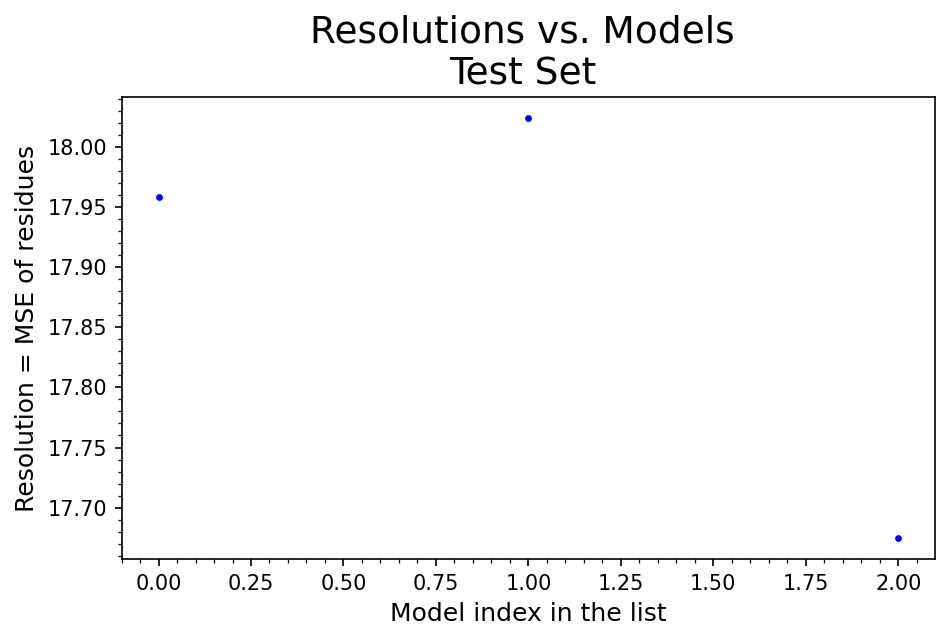

In [35]:
plot_resolutions(resolutions_test)

Model: "gelu_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 8)                 72        
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
72/72 [==============================] - 0s 648us/step


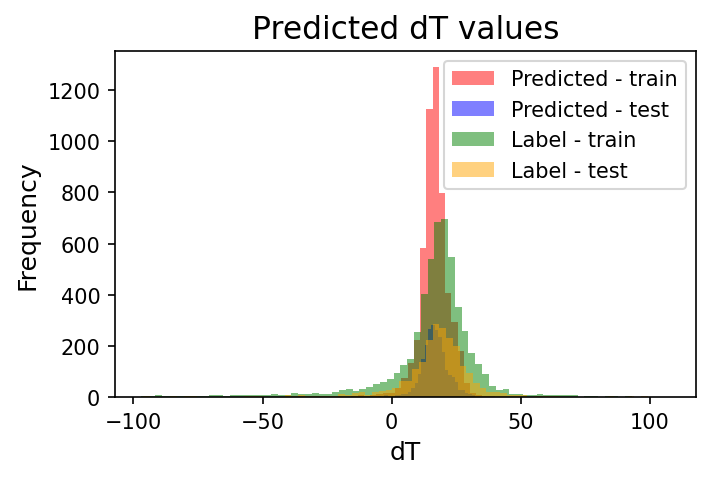

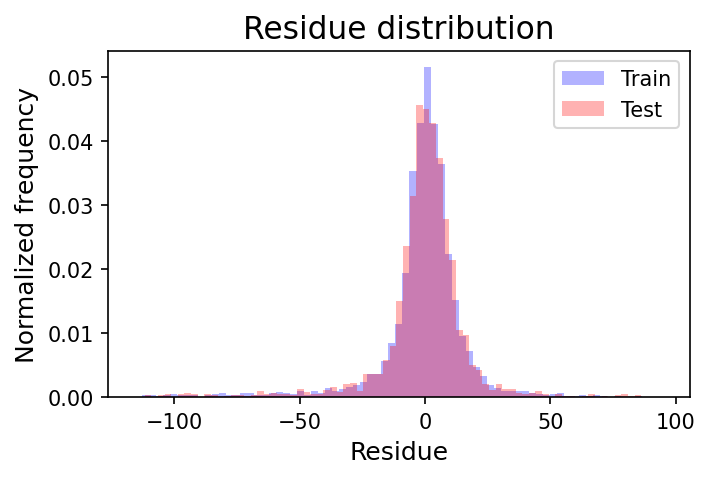

Method: std
Resolution - train set: 18.36594665084394
Resolution - test set: 18.023833330774178


In [36]:
# Model at index to be investigated
index = 1

# Model summary
models_list[index].summary()
predictor(models_list[index], data=data_np, plot_hist=True,
          add_labelvals=True, add_resolutions=True,
         plot_residues=True)

**Reload models from Grid Search**

In [37]:
models_list, resolutions_train, resolutions_test = reload_grid_search("paths_for_models_gelu_(1, 6, 10, 2).csv",)

72/72 [==============================] - 0s 592us/step


##### Run the grid search

Try combinations that have between 1 and 10 nodes per layer. The upper bound may be changed, if necessary, but I find it unlikely to be more useful than having a deeper NN.

**2 layers** - 1257 sec

In [8]:
models_list, resolutions_train, resolutions_test = grid_search((2, 1, 10, 1), layer_activation='gelu')




72/72 [==============================] - 0s 620us/step


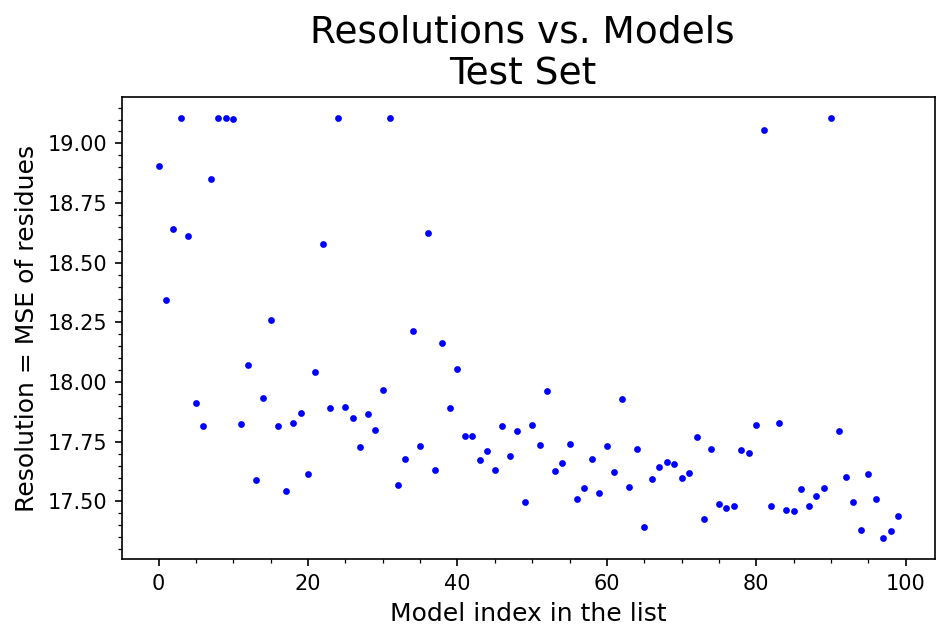

In [9]:
plot_resolutions(resolutions_test)

Model: "gelu_10_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_291 (Dense)           (None, 10)                90        
                                                                 
 dense_292 (Dense)           (None, 8)                 88        
                                                                 
 dense_293 (Dense)           (None, 1)                 9         
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
72/72 [==============================] - 0s 637us/step


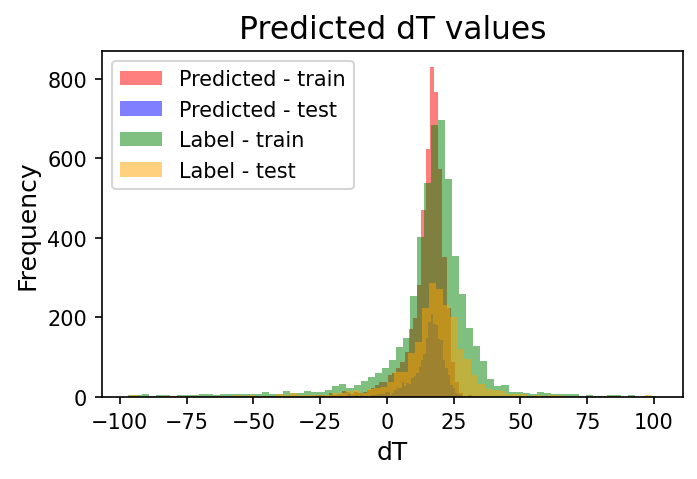

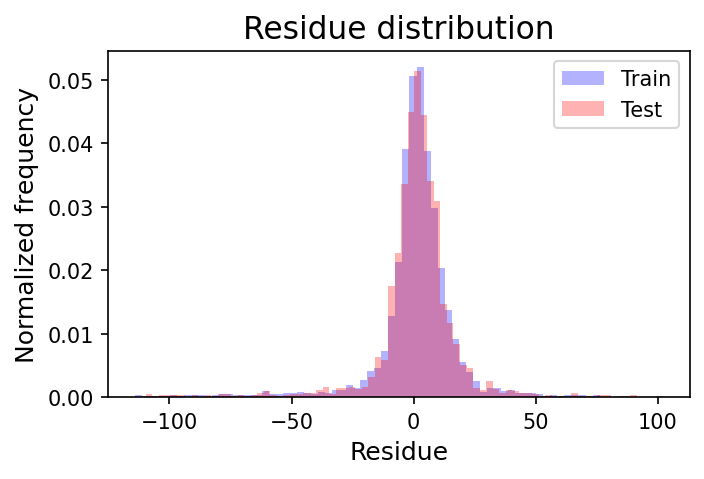

Method: std
Resolution - train set: 17.83173788365581
Resolution - test set: 17.34652112967523


In [10]:
# Model at index to be investigated
index = 97

# Model summary
models_list[index].summary()
predictor(models_list[index], data=data_np, plot_hist=True,
          add_labelvals=True, add_resolutions=True,
         plot_residues=True)